<a href="https://colab.research.google.com/github/karolina-palka/SVHN_dataset_project/blob/main/Capstone_Project_SVHN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (you could download the notebook with File -> Download .ipynb, open the notebook locally, and then File -> Download as -> PDF via LaTeX), and then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import tensorflow as tf
from scipy.io import loadmat
from os.path import dirname, join as pjoin

For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images.

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

The train and test datasets required for this project can be downloaded from [here](http://ufldl.stanford.edu/housenumbers/train.tar.gz) and [here](http://ufldl.stanford.edu/housenumbers/test.tar.gz). Once unzipped, you will have two files: `train_32x32.mat` and `test_32x32.mat`. You should store these files in Drive for use in this Colab notebook.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [2]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
train = loadmat('gdrive/MyDrive/train_32x32.mat' )
test = loadmat('gdrive/MyDrive/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Softmax, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [203]:
train_data, train_labels = train["X"]/255., train["y"]
test_data, test_labels = test["X"]/255., test["y"]

In [6]:
train.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [7]:
print(train_data.shape, test_data.shape)

(32, 32, 3, 73257) (32, 32, 3, 26032)


In [8]:
train_targets = train_labels -1
test_targets = test_labels -1

In [9]:
# Convert data images to grayscale

def convert_to_grayscale(data_set ):
  n = len(data_set[0,0,0,:])
  #n = 10
  gray_images = []
  for i in range(0, n):
    img = data_set[:,:,:,i]
    R, G, B = img[:,:,0], img[:,:,1], img[:,:,2]
    imgGray =  (R + G + B)/(3)
    imgGray = imgGray[..., np.newaxis]
    gray_images.append(imgGray)
  gray_images = np.asarray(gray_images)
  return gray_images

In [10]:
gray_test = convert_to_grayscale(test_data)
gray_test.shape

(26032, 32, 32, 1)

In [11]:
gray_train = convert_to_grayscale(train_data)
gray_train.shape


(73257, 32, 32, 1)

In [12]:
def take_indices_at_random(data, targets, number_of_choices):
  n = len(data)
  random_inx = np.random.choice(n, number_of_choices)
  random_test_images = data[random_inx, ...]
  predictions = targets[random_inx]
  return [random_test_images, predictions]

In [13]:
def plot_10_images_at_random(data, targets):
  
  random_test_images, predictions = take_indices_at_random(data, targets, 10)
  fig, ax = plt.subplots(1, 10, figsize=(20, 4))
  for i in range(0, 10):
    ax[i].set_title(f'Class:{predictions[i]}')
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)
    ax[i].imshow(np.squeeze(random_test_images[i]), cmap='gray')
    

In [14]:
train_data = np.transpose(train_data, [3, 0, 1, 2])
test_data = np.transpose(test_data, [3, 0, 1, 2])
print(train_data.shape, test_data.shape)

(73257, 32, 32, 3) (26032, 32, 32, 3)


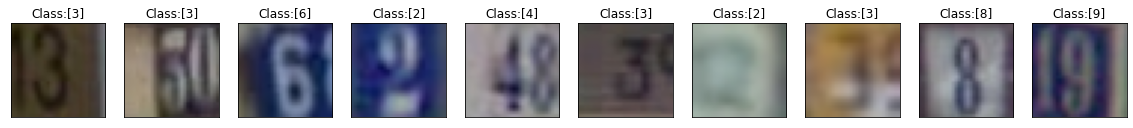

In [15]:
plot_10_images_at_random(train_data, train_labels)

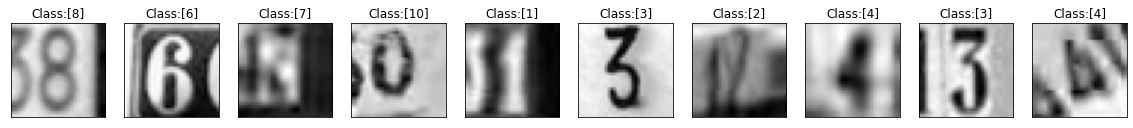

In [16]:
plot_10_images_at_random(gray_train, train_labels)


## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [163]:
def get_model(input_shape):
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(256, activation="relu", kernel_initializer="he_normal", 
              bias_initializer='Ones'),
        Dense(256, activation="relu"),
        Dense(256, activation = "relu"),
        Dense(128, activation = "relu"),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [164]:
#Clean the model layers and the checkpoints files
tf.keras.backend.clear_session()
! rm -r checkpoints*MPL

rm: cannot remove 'checkpoints*MPL': No such file or directory


In [165]:
model = get_model(gray_train[0].shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 428,170
Trainable params: 428,170
Non-trainable params: 0
__________________________________________________

## Function definitions

In [166]:
def get_test_accuracy(model, x_test, y_test):
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))

In [167]:
def get_checkpoint_every_epoch(path):
    checkpoint_path = path
    checkpoint = ModelCheckpoint(filepath=checkpoint_path, frequency = 'epoch',
                             save_weights_only=True, verbose=1)
    return checkpoint

def get_checkpoint_best_only(path):
    checkpoint_best_path = path
    checkpoint = ModelCheckpoint(monitor="loss", filepath=checkpoint_best_path, frequency = 'epoch',
                             save_weights_only=True, save_best_only=True, verbose=1)
    return checkpoint

def get_early_stopping():
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', mode="min", patience=5)
    return early_stopping

## Training the model

In [168]:
checkpoint_every_epoch = get_checkpoint_every_epoch('checkpoints_every_epoch_MPL/checkpoint_{epoch:03d}')
checkpoint_best_only = get_checkpoint_best_only('checkpoints_best_only_MPL/checkpoint')
early_stopping = get_early_stopping()

In [169]:
callbacks = [checkpoint_every_epoch, checkpoint_best_only, early_stopping]
history = model.fit(gray_train, train_targets, epochs=30, validation_data=(gray_test, test_targets), callbacks=callbacks)

Epoch 1/30
2290/2290 [==============================] - 12s 5ms/step - loss: 1.8244 - accuracy: 0.3528 - val_loss: 1.6176 - val_accuracy: 0.4664

Epoch 00001: saving model to checkpoints_every_epoch_MPL/checkpoint_001

Epoch 00001: loss improved from inf to 1.82445, saving model to checkpoints_best_only_MPL/checkpoint
Epoch 2/30
2290/2290 [==============================] - 11s 5ms/step - loss: 1.2457 - accuracy: 0.5937 - val_loss: 1.3585 - val_accuracy: 0.5717

Epoch 00002: saving model to checkpoints_every_epoch_MPL/checkpoint_002

Epoch 00002: loss improved from 1.82445 to 1.24570, saving model to checkpoints_best_only_MPL/checkpoint
Epoch 3/30
2290/2290 [==============================] - 11s 5ms/step - loss: 1.0668 - accuracy: 0.6597 - val_loss: 1.1722 - val_accuracy: 0.6366

Epoch 00003: saving model to checkpoints_every_epoch_MPL/checkpoint_003

Epoch 00003: loss improved from 1.24570 to 1.06677, saving model to checkpoints_best_only_MPL/checkpoint
Epoch 4/30
2290/2290 [==========

## Visualization of the results

In [170]:
def plotting_accuracy(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Accuracy vs. epochs')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='lower right')
  plt.show() 

In [171]:
def plotting_loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Loss vs. epochs')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='upper right')
  plt.show() 

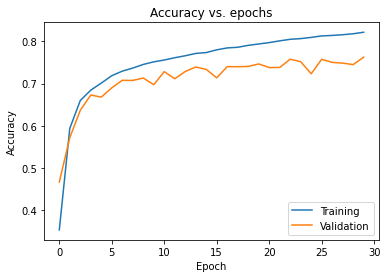

In [172]:
# Plotting the accuracy vs. epochs graph 

plotting_accuracy(history)

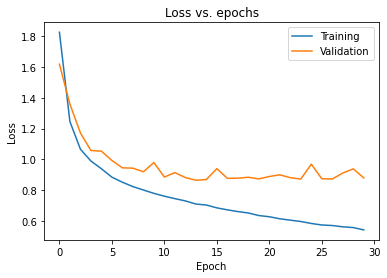

In [173]:
# Plotting the loss vs. epochs graph

plotting_loss(history)

In [174]:
test_loss, test_acc = model.evaluate(gray_test, test_targets, verbose=0)
print("Test loss: {:.3f}\nTest accuracy: {:.2f}%".format(test_loss, 100 * test_acc))

Test loss: 0.881
Test accuracy: 76.27%


## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [175]:
def get_new_conv_model(input_shape):
    model = Sequential([
        Conv2D(8, (3, 3), activation='relu', padding='SAME',input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        BatchNormalization(),
        Conv2D(16, (3, 3), activation='relu', padding='SAME'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        BatchNormalization(),
        Flatten(name = 'flatten'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [162]:
#Clean the model layers and the checkpoints files
#tf.keras.backend.clear_session()
#! rm -r checkpoints*CNN

In [176]:
conv_model = get_new_conv_model(gray_train[0].shape)
conv_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 8)         0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 8)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 8)         32        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 16)         

In [177]:
checkpoint_every_epoch_conv = get_checkpoint_every_epoch('checkpoints_every_epoch_CNN/checkpoint_{epoch:03d}')
checkpoint_best_only_conv = get_checkpoint_best_only('checkpoints_best_only_CNN/checkpoint')
early_stopping = get_early_stopping()

## Training the model

In [178]:
callbacks_conv = [checkpoint_every_epoch_conv, checkpoint_best_only_conv, early_stopping]
history_conv = conv_model.fit(gray_train, train_targets, epochs=30, validation_data=(gray_test, test_targets), callbacks=callbacks_conv)

Epoch 1/30
2290/2290 [==============================] - 55s 24ms/step - loss: 1.2885 - accuracy: 0.5630 - val_loss: 0.6387 - val_accuracy: 0.8057

Epoch 00001: saving model to checkpoints_every_epoch_CNN/checkpoint_001

Epoch 00001: loss improved from inf to 1.28848, saving model to checkpoints_best_only_CNN/checkpoint
Epoch 2/30
2290/2290 [==============================] - 54s 24ms/step - loss: 0.7091 - accuracy: 0.7748 - val_loss: 0.5474 - val_accuracy: 0.8309

Epoch 00002: saving model to checkpoints_every_epoch_CNN/checkpoint_002

Epoch 00002: loss improved from 1.28848 to 0.70912, saving model to checkpoints_best_only_CNN/checkpoint
Epoch 3/30
2290/2290 [==============================] - 54s 24ms/step - loss: 0.6252 - accuracy: 0.8008 - val_loss: 0.5285 - val_accuracy: 0.8319

Epoch 00003: saving model to checkpoints_every_epoch_CNN/checkpoint_003

Epoch 00003: loss improved from 0.70912 to 0.62523, saving model to checkpoints_best_only_CNN/checkpoint
Epoch 4/30
2290/2290 [=======

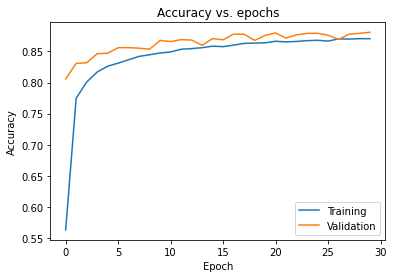

In [179]:
plotting_accuracy(history_conv)

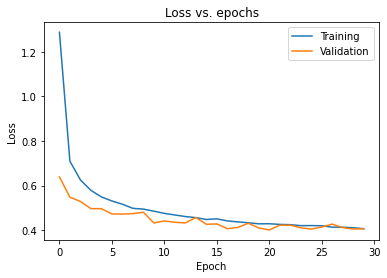

In [180]:
plotting_loss(history_conv)

In [181]:
test_loss, test_acc = conv_model.evaluate(gray_test, test_targets, verbose=0)
print("Test loss: {:.3f}\nTest accuracy: {:.2f}%".format(test_loss, 100 * test_acc))

Test loss: 0.406
Test accuracy: 88.10%


## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

## Loading best weights for MLP and CNN

In [152]:
def get_model_last_epoch(model,dirname):
    checkpoint_path = tf.train.latest_checkpoint(dirname)
    model.load_weights(checkpoint_path)
    return model

In [153]:
def get_model_best_epoch(model, dirname):
    checkpoint_path = tf.train.latest_checkpoint(dirname)
    model.load_weights(checkpoint_path)
    return model

In [186]:
model_last_epoch_MPL = get_model_last_epoch(get_model(gray_train[0].shape), 'checkpoints_every_epoch_MPL')
model_best_epoch_MPL = get_model_best_epoch(get_model(gray_train[0].shape), 'checkpoints_best_only_MPL')
print('Model with last epoch weights:')
get_test_accuracy(model_last_epoch, gray_test, test_targets)
print('')
print('Model with best epoch weights:')
get_test_accuracy(model_best_epoch, gray_test, test_targets)

Model with last epoch weights:
accuracy: 0.777

Model with best epoch weights:
accuracy: 0.777


In [188]:
model_last_epoch_CNN = get_model_last_epoch(get_new_conv_model(gray_train[0].shape), 'checkpoints_every_epoch_CNN')
model_best_epoch_CNN = get_model_best_epoch(get_new_conv_model(gray_train[0].shape), 'checkpoints_best_only_CNN')
print('Model with last epoch weights:')
get_test_accuracy(model_last_epoch, gray_test, test_targets)
print('')
print('Model with best epoch weights:')
get_test_accuracy(model_best_epoch_conv, gray_test, test_targets)

Model with last epoch weights:
accuracy: 0.777

Model with best epoch weights:
accuracy: 0.881


## Accuracy and loss comparison

In [189]:
test_loss, test_acc = model_best_epoch_MPL.evaluate(gray_test, test_targets, verbose=0)
print("Test loss: {:.3f}\nTest accuracy: {:.2f}%".format(test_loss, 100 * test_acc))

Test loss: 0.881
Test accuracy: 76.27%


In [190]:
test_loss, test_acc = model_best_epoch_CNN.evaluate(gray_test, test_targets, verbose=0)
print("Test loss: {:.3f}\nTest accuracy: {:.2f}%".format(test_loss, 100 * test_acc))


Test loss: 0.406
Test accuracy: 88.10%


## Model prediction on randomly selected images

In [204]:
random_test_images, random_test_labels = take_indices_at_random(gray_test, test_labels, 5)

In [205]:
predictions_MPL = model_best_epoch_MPL.predict(random_test_images) 

In [206]:
predictions_CNN = model_best_epoch_CNN.predict(random_test_images) 

In [207]:
classes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [208]:
# Get model predictions on randomly selected test images

def plot_5_images_at_random(predictions, model):
  fig, axes = plt.subplots(5, 2, figsize=(16, 12))
  fig.subplots_adjust(hspace=0.4, wspace=-0.2)

  for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
      axes[i, 0].imshow(np.squeeze(image), cmap='gray')
      axes[i, 0].get_xaxis().set_visible(False)
      axes[i, 0].get_yaxis().set_visible(False)
      axes[i, 0].text(10., -1.5, f'Digit {label}')
      axes[i, 1].bar(classes, prediction)
      axes[i, 1].set_xticks(classes)
      axes[i, 1].set_title(f"Categorical distribution. Model {model} prediction:{np.argmax(prediction)+1}")
    
  plt.show()

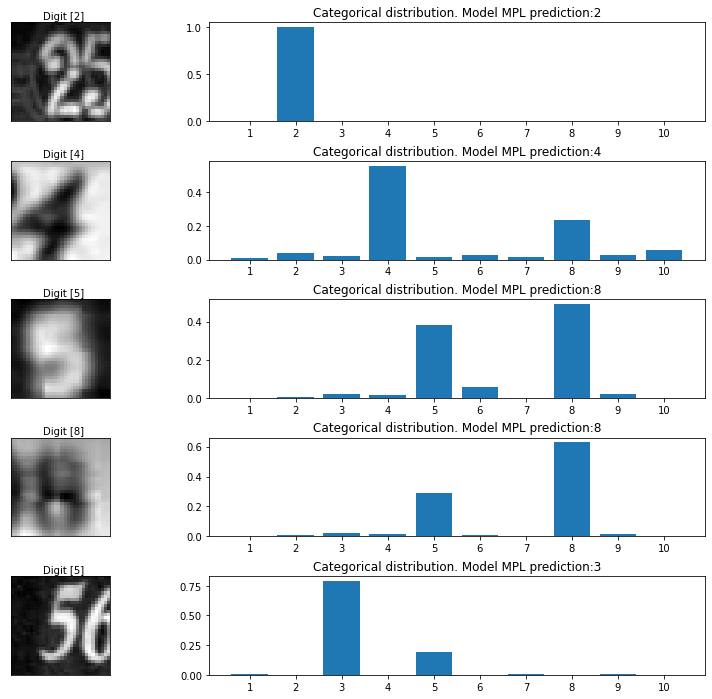

In [209]:
plot_5_images_at_random(predictions_MPL, "MPL")

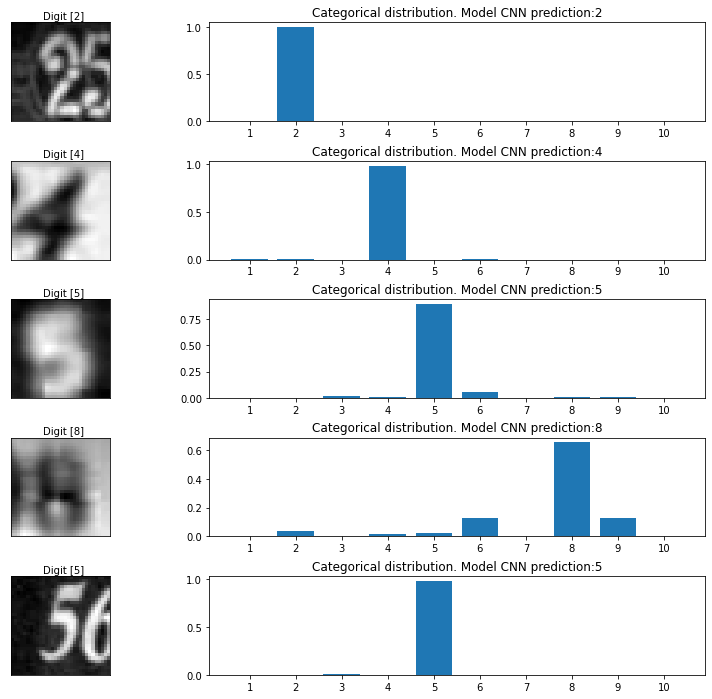

In [210]:
plot_5_images_at_random(predictions_CNN, "CNN")